In [60]:
!rm -rf COVID-19
!git clone https://github.com/pcm-dpc/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 954 (delta 6), reused 11 (delta 5), pack-reused 928
Receiving objects: 100% (954/954), 31.80 MiB | 526.00 KiB/s, done.
Resolving deltas: 100% (645/645), done.


In [55]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
import matplotlib as mpl

fig_size = [28.0, 20.0]
params = {'backend': 'ps',
           'font.size': 18,
           'axes.labelsize': 25,
           'axes.labelweight': 'bold',
           'lines.linewidth': 1.5,
           'legend.fontsize': 18,
           'xtick.labelsize': 18,
           'ytick.labelsize': 18,
           'text.usetex': True,
           #'text.latex.preamble': [r'\boldmath'],
           'figure.figsize': fig_size,
           'savefig.bbox': 'tight'}
mpl.rcParams.update(params)

In [49]:
def func(y, t, N, alpha, beta0, beta1, beta2, gamma0, gamma1, gamma2, delta, p0, p1):
    # S, I, R values assigned from vector
    S, E, I0, I1, I2, R, D = y
    # differential equations
    dDdt = delta * I2
    dRdt = gamma0 * I0 + gamma1 * I1 + gamma2 * I2
    dI2dt = p1 * I1 - gamma2 * I2 - delta * I2
    dI1dt = p0 * I0 - gamma1 * I1 - p1 * I1
    dI0dt = alpha * E - gamma0 * I0 - p0 * I0
    dEdt = beta0 * I0 * S /N + beta1 * I1 * S/N + beta2 * I2 * S/N - alpha * E
    dSdt = - beta0 * I0 * S/N - beta1 * I1 * S/N - beta2 * I2 * S/N
    return dSdt, dEdt, dI0dt, dI1dt, dI2dt, dRdt, dDdt

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv('COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv', parse_dates=['data'], date_parser=dateparse)
df_sum = df.groupby(by='data').sum()

In [4]:
data = df_sum[datetime(2020, 2, 27, 18):]

In [5]:
I2 = data.terapia_intensiva
I1 = data.ricoverati_con_sintomi
I0 = data.totale_attualmente_positivi
R = data.dimessi_guariti
D = data.deceduti

In [50]:
def run_model(y_0, n_days, N, alpha, beta0, beta1, beta2, gamma0, gamma1, gamma2, delta, p0, p1):
    print(alpha, beta0, beta1, beta2, gamma0, gamma1, gamma2, delta, p0, p1)
    t = np.linspace(0, n_days, n_days)
    y_th = odeint(func, y_0, t, args=(N, alpha, beta0, beta1, beta2, gamma0, gamma1, gamma2, delta, p0, p1))
    return t, y_th.T

0.1923076923076923 0.8275862068965517 0 0 0.07207207207207209 0.17500000000000002 0.033333333333333326 0.06666666666666667 0.018018018018018014 0.075


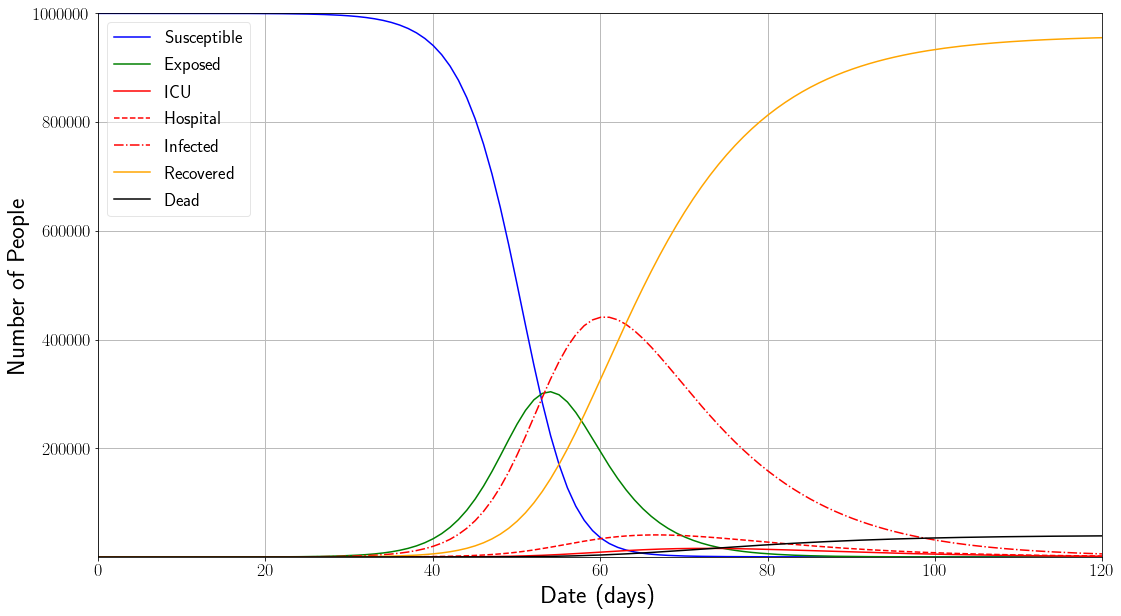

In [58]:
N = 1000000
num_days = 600
R_factor = 2.4
t_inc = 5.20
t_inf = 2.9
t_mild = 11.1
t_sev = 4.0
t_crit = 10.0
CFR = 0.04
frac_mild_sev_crit = [0.8, 0.14, 0.06]
y_0 = N-1, 0, 1, 0, 0, 0, 0
X, Y = run_model(y_0, num_days, N, 
                 1/t_inc, 
                 R_factor/t_inf, 0, 0, 
                 1/t_mild*frac_mild_sev_crit[0], 
                 1/t_sev * frac_mild_sev_crit[1]/(frac_mild_sev_crit[1]+frac_mild_sev_crit[2]),
                 1/t_crit * (1-CFR/frac_mild_sev_crit[2]),
                 1/t_crit * CFR/frac_mild_sev_crit[2],
                 1/t_mild * (1-frac_mild_sev_crit[0]), 
                 1/t_sev * frac_mild_sev_crit[2]/(frac_mild_sev_crit[1]+frac_mild_sev_crit[2])
                )

Sth, Eth, I0th, I1th, I2th, Rth, Dth = Y
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(X, Sth, 'blue', lw=1.5, label='Susceptible')
ax.plot(X, Eth, 'green', lw=1.5, label='Exposed')
ax.plot(X, I2th, 'red', lw=1.5, label='ICU')
ax.plot(X, I1th+I2th, 'red', lw=1.5, ls='--', label='Hospital')
ax.plot(X, I0th+I1th+I2th, 'red', lw=1.5, ls='-.', label='Infected')
ax.plot(X, Rth, 'orange', lw=1.5, label='Recovered')
ax.plot(X, Dth, 'black', lw=1.5, label='Dead')
ax.set_xlabel('Date (days)')
ax.set_ylabel('Number of People')
#ax.set_yscale('log')
ax.set_ylim(1,N)
ax.set_xlim(0,120)
ax.grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')
#ax.xaxis.set_major_formatter(major_formatter)
ax.tick_params(axis='x')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

plt.savefig('covid19-generic.png')

plt.show()